In [1]:
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.misc import imread
from alexnet import AlexNet
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
nb_classes = 43
epochs = 10
batch_size = 128

with open('./train.p', 'rb') as f:
    data = pickle.load(f)

X_train, X_val, y_train, y_val = train_test_split(data['features'], data['labels'], test_size=0.33, random_state=0)

features = tf.placeholder(tf.float32, (None, 32, 32, 3))
labels = tf.placeholder(tf.int64, None)
resized = tf.image.resize_images(features, (227, 227))

# Returns the second final layer of the AlexNet model,
# this allows us to redo the last layer for the traffic signs
# model.
fc7 = AlexNet(resized, feature_extract=True)
fc7 = tf.stop_gradient(fc7)
shape = (fc7.get_shape().as_list()[-1], nb_classes)
fc8W = tf.Variable(tf.truncated_normal(shape, stddev=1e-2))
fc8b = tf.Variable(tf.zeros(nb_classes))
logits = tf.nn.xw_plus_b(fc7, fc8W, fc8b)

saver = tf.train.Saver()

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
loss_op = tf.reduce_mean(cross_entropy)
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op, var_list=[fc8W, fc8b])
init_op = tf.global_variables_initializer()

preds = tf.arg_max(logits, 1)
accuracy_op = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))


def eval_on_data(X, y, sess):
    total_acc = 0
    total_loss = 0
    for offset in range(0, X.shape[0], batch_size):
        end = offset + batch_size
        X_batch = X[offset:end]
        y_batch = y[offset:end]

        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={features: X_batch, labels: y_batch})
        total_loss += (loss * X_batch.shape[0])
        total_acc += (acc * X_batch.shape[0])

    return total_loss/X.shape[0], total_acc/X.shape[0]

with tf.Session() as sess:
    sess.run(init_op)

    for i in range(epochs):
        # training
        X_train, y_train = shuffle(X_train, y_train)
        t0 = time.time()
        for offset in range(0, X_train.shape[0], batch_size):
            end = offset + batch_size
            sess.run(train_op, feed_dict={features: X_train[offset:end], labels: y_train[offset:end]})

        val_loss, val_acc = eval_on_data(X_val, y_val, sess)
        print("Epoch", i+1)
        print("Time: %.3f seconds" % (time.time() - t0))
        print("Validation Loss =", val_loss)
        print("Validation Accuracy =", val_acc)
        print("")
    saver.save(sess, './alexnet')
    print("Model saved!")


Epoch 1
Time: 98.796 seconds
Validation Loss = 0.570516066927
Validation Accuracy = 0.841344479006

Epoch 2
Time: 95.451 seconds
Validation Loss = 0.379196853878
Validation Accuracy = 0.902473005589

Epoch 3
Time: 95.458 seconds
Validation Loss = 0.289927116621
Validation Accuracy = 0.926071055008

Epoch 4
Time: 95.456 seconds
Validation Loss = 0.231105743214
Validation Accuracy = 0.943660745447

Epoch 5
Time: 95.465 seconds
Validation Loss = 0.210027851271
Validation Accuracy = 0.947927550981

Epoch 6
Time: 95.446 seconds
Validation Loss = 0.190457944197
Validation Accuracy = 0.95106234722

Epoch 7
Time: 95.435 seconds
Validation Loss = 0.168736438642
Validation Accuracy = 0.955590386189

Epoch 8
Time: 95.440 seconds
Validation Loss = 0.155134805198
Validation Accuracy = 0.959683036875

Epoch 9
Time: 95.445 seconds
Validation Loss = 0.148924623241
Validation Accuracy = 0.960989201995

Epoch 10
Time: 95.428 seconds
Validation Loss = 0.134092179157
Validation Accuracy = 0.964994775402



Now we can test on the new images we found.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
df = pd.read_csv('signnames.csv')
class_names = df['SignName']

Image 0
Road work: 0.876
Slippery road: 0.124
Priority road: 0.000
Dangerous curve to the left: 0.000
No passing: 0.000

Image 1
Stop: 1.000
No entry: 0.000
Speed limit (30km/h): 0.000
Speed limit (50km/h): 0.000
Speed limit (120km/h): 0.000

Time: 0.663 seconds


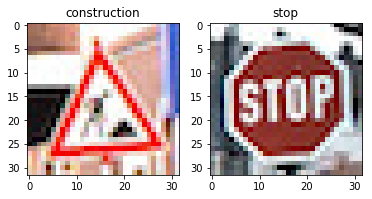

In [20]:
#show images first
plt.subplot(1, 2, 1)
plt.imshow(imread("construction.jpg"))
plt.title("construction")
plt.subplot(1, 2, 2)
plt.imshow(imread("stop.jpg"))
plt.title("stop")

#predict the image with top 5 probability
sess = tf.Session()
# Read Images
im1 = imread("construction.jpg").astype(np.float32)
im2 = imread("stop.jpg").astype(np.float32)
im1 = im1 - np.mean(im1)
im2 = im2 - np.mean(im2)

# Run Inference
t = time.time()
# output = sess.run(preds, feed_dict={features: [im1, im2]})

pred = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = sess.run(pred, feed_dict={features: [im1, im2]})
    
# # Print Output
for input_im_ind in range(output.shape[0]):
    inds = np.argsort(output)[input_im_ind, :]
    print("Image", input_im_ind)
    for i in range(5):
        print("%s: %.3f" % (class_names[inds[-1 - i]], output[input_im_ind, inds[-1 - i]]))
    print()

print("Time: %.3f seconds" % (time.time() - t))